In [151]:
import numpy as np
import pandas as pd
import sys
import tensorflow as tf
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

In [152]:
def add_data(hmap, data, ts):
    if ts not in hmap:
        hmap[ts] = data
    elif data != hmap[ts]:
        print(f"WHY {ts} is already in: {hmap}")

In [153]:
def create_df(filename, write=False):
    print(filename)
    with open(filename, 'r') as file:
        timestamps = []
        accel_x = []
        accel_y = []
        accel_z = []
        gyro_x = []
        gyro_y = []
        gyro_z = []

        for line in file:
            data_line = line.strip()
            if data_line and data_line[0].isdigit():
                # print(data_line)
                node_num, timestamp, ax, ay, az, gx, gy, gz, mx, my, mz = data_line.split(",")
                timestamps.append(int(timestamp))
                accel_x.append(float(ax))
                accel_y.append(float(ay))
                accel_z.append(float(az))
                gyro_x.append(float(gx))
                gyro_y.append(float(gy))
                gyro_z.append(float(gz))

        df = pd.DataFrame({'timestamp': timestamps, 
                           'accel_x': accel_x, 
                           'accel_y': accel_y, 
                           'accel_z': accel_z, 
                           'gyro_x': gyro_x, 
                           'gyro_y': gyro_y, 
                           'gyro_z': gyro_z})
        cleaned_df = df.interpolate(method="linear", limit_direction="both")
        name = "../csvs2/" + filename.split("/")[-1].split(".")[0] + "_df.csv"
        if write:
            cleaned_df.to_csv(name, index=False)
        print(cleaned_df.head())
        return cleaned_df

In [154]:
def plot_df(df, title):
    plt.figure(figsize=(10, 8))
    plt.plot(df["timestamp"], df["accel_x"], label="accel_x")
    plt.plot(df["timestamp"], df["accel_y"], label="accel_y")
    plt.plot(df["timestamp"], df["accel_z"], label="accel_z")
    plt.plot(df["timestamp"], df["gyro_x"], label="gyro_x")
    plt.plot(df["timestamp"], df["gyro_y"], label="gyro_y")
    plt.plot(df["timestamp"], df["gyro_z"], label="gyro_z")


    peaks, properties = find_peaks(df["accel_y"], height=0, distance=120)
    plt.plot(df["timestamp"].iloc[peaks], df["accel_y"].iloc[peaks], "rx", label="peaks")

    print(properties)

    # df.plot(x="timestamp", figsize=(10,8))
    # ay = np.array(df["accel_y"])
    # peaks, _ = find_peaks(df["accel_y"], height=0)
    print(f"peaks: {peaks}")
    # plt.plot(peaks, df["accel_y"][peaks], "x")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.xlabel("Timestamp")
    plt.ylabel("IMU Data")
    plt.show()

In [155]:
training_files = ["../data2/bicep_curl/bicep_jake_set1_reps10_1.log",
                  "../data2/bicep_curl/bicep_suzan_set1_reps10_1.log", 
                  "../data2/bicep_curl/bicep_udai_set1_reps10_1.log", 
                  "../data2/shoulder_press/suzan_shoulder_set1.log", 
                  "../data/shoulder_press/jake_shoulder_set1.log", 
                  "../data/shoulder_press/udai_shoulder_set1.log", 
                  "../data/row/suzan_row_set1.log", 
                  "../data/row/jake_row_set1.log", 
                  "../data/row/udai_row_set1.log", 
                  "../data/rdl/suzan_rdl_set1.log", 
                  "../data/rdl/jake_rdl_set1.log", 
                  "../data/rdl/jessica_rdl_set1.log", 
                  "../data/squat/suzan_squat_set1.log", 
                  "../data/squat/jake_squat_set1.log", 
                  "../data/squat/udai_squat_set1.log"]

test_files = ["../data/bicep_curl/suzan_bicep_set2.log", 
              "../data/bicep_curl/jake_bicep_set2.log", 
              "../data/bicep_curl/udai_bicep_set2.log", 
              "../data/shoulder_press/suzan_shoulder_set2.log", 
              "../data/shoulder_press/jake_shoulder_set2.log", 
              "../data/shoulder_press/udai_shoulder_set2.log", 
              "../data/row/suzan_row_set2.log", 
              "../data/row/jake_row_set2.log", 
              "../data/row/udai_row_set2.log", 
              "../data/rdl/suzan_rdl_set2.log", 
              "../data/rdl/jake_rdl_set2.log", 
              "../data/rdl/jessica_rdl_set2.log", 
              "../data/squat/suzan_squat_set2.log", 
              "../data/squat/jake_squat_set2.log", 
              "../data/squat/udai_squat_set2.log"]

../data2/bicep_curl/bicep_jake_set1_reps10_1.csv
   timestamp  accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z
0     290375   -1.572   -7.716    5.983  -0.204   0.038   0.077
1     290379   -1.625   -7.711    6.048  -0.161   0.027   0.073
2     290382   -1.625   -7.711    6.048  -0.161   0.027   0.073
3     290386   -1.687   -7.732    6.049  -0.161   0.027   0.068
4     290409   -1.742   -7.766    6.050  -0.053  -0.007   0.054
{'peak_heights': array([10.177,  9.74 , 10.458,  9.173,  9.936, 10.652, 10.677, 10.165,
        9.657,  9.905])}
peaks: [ 278  527  652  782  921 1096 1290 1441 1618 1782]


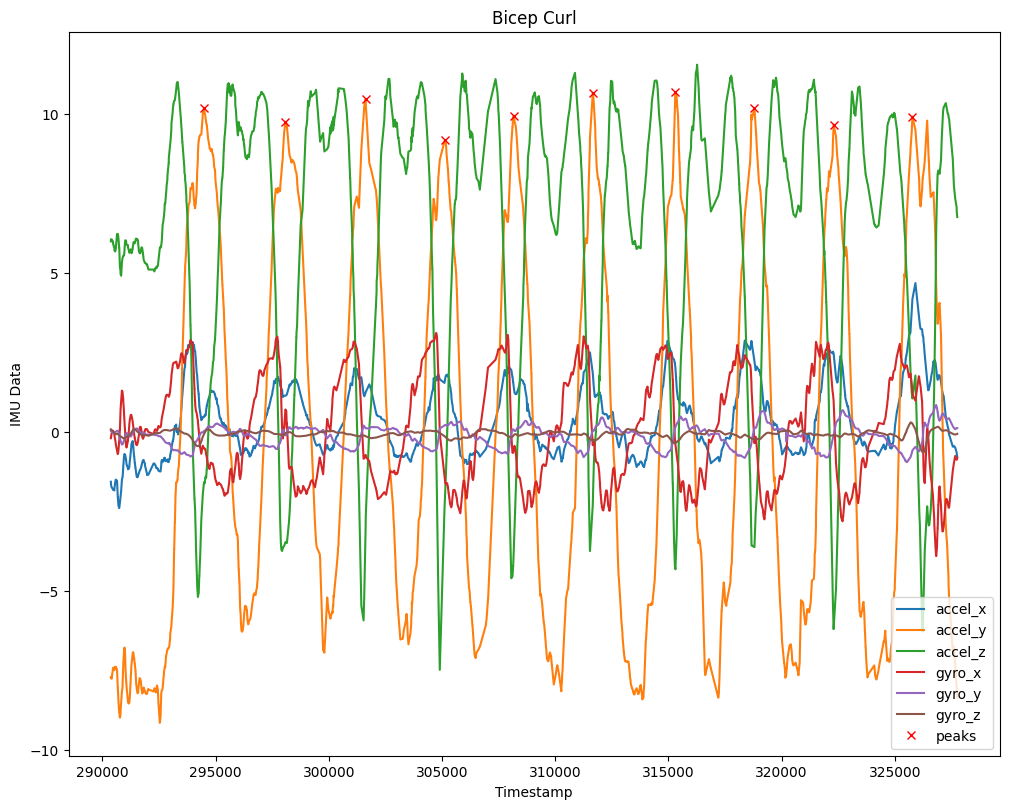

In [156]:
file = "../data2/bicep_curl/bicep_jake_set1_reps10_1.csv"
df = create_df(file)
plot_df(df, "Bicep Curl")

../data2/bicep_curl/bicep_suzan_set1_reps10_1.csv
   timestamp  accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z
0      81488   -1.497   -8.644    3.996  -0.105  -0.048  -0.060
1      81492   -1.497   -8.644    3.996  -0.105  -0.048  -0.060
2      81496   -1.522   -8.663    4.074  -0.105  -0.048  -0.060
3      81705   -1.516   -8.778    3.862   0.114  -0.100  -0.059
4      81730   -1.517   -8.743    3.927  -0.043  -0.071  -0.067
{'peak_heights': array([9.444, 9.629, 9.461, 9.636, 9.421, 8.941, 9.302, 9.46 , 8.754,
       9.395, 8.983, 9.107])}
peaks: [ 139  320  549  784 1055 1188 1321 1565 1687 1916 2047 2253]


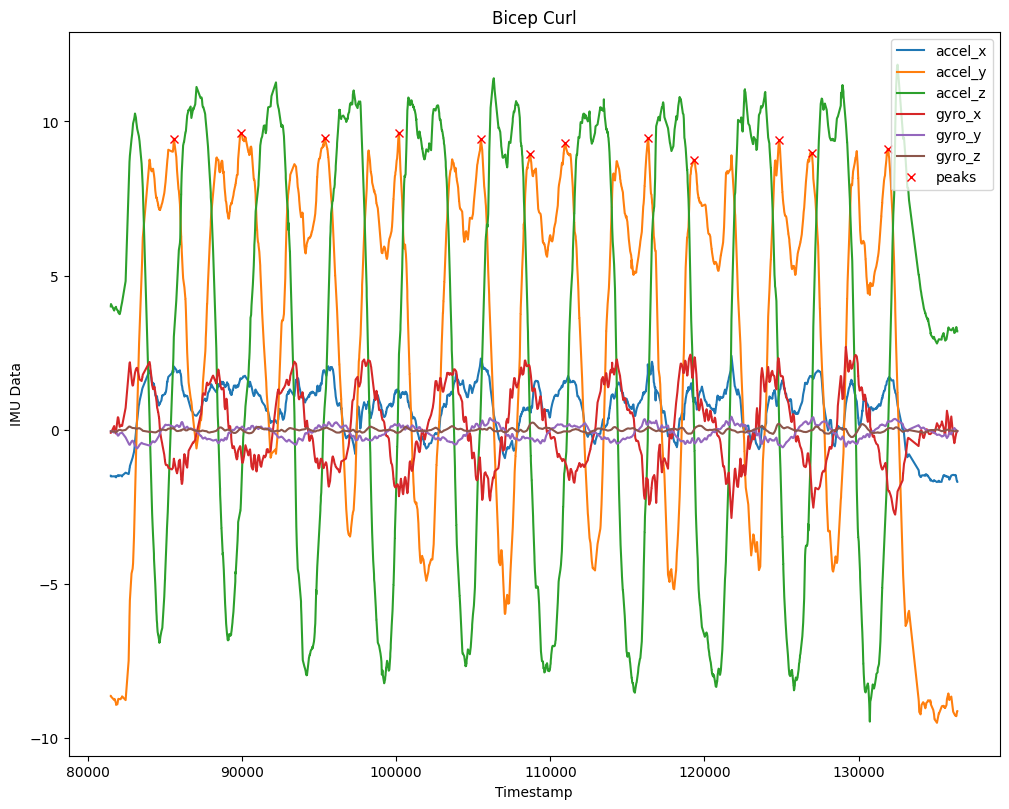

In [157]:
file = "../data2/bicep_curl/bicep_suzan_set1_reps10_1.csv"
df = create_df(file)
plot_df(df, "Bicep Curl")

../data2/bicep_curl/bicep_udai_set1_reps10_1.csv
   timestamp  accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z
0     208565   -1.065   -5.015    7.876   0.125  -0.076  -0.017
1     208569   -1.065   -5.015    7.876   0.125  -0.076  -0.017
2     208573   -1.065   -5.091    7.829   0.125  -0.076  -0.017
3     208576   -1.064   -5.091    7.829   0.050  -0.064  -0.020
4     208599   -1.137   -5.216    7.834  -0.078  -0.034  -0.020
{'peak_heights': array([8.91 , 8.358, 7.64 , 9.842, 8.286, 7.89 , 8.461, 8.54 , 8.966,
       8.313])}
peaks: [ 172  375  495  632  782  962 1102 1255 1409 1615]


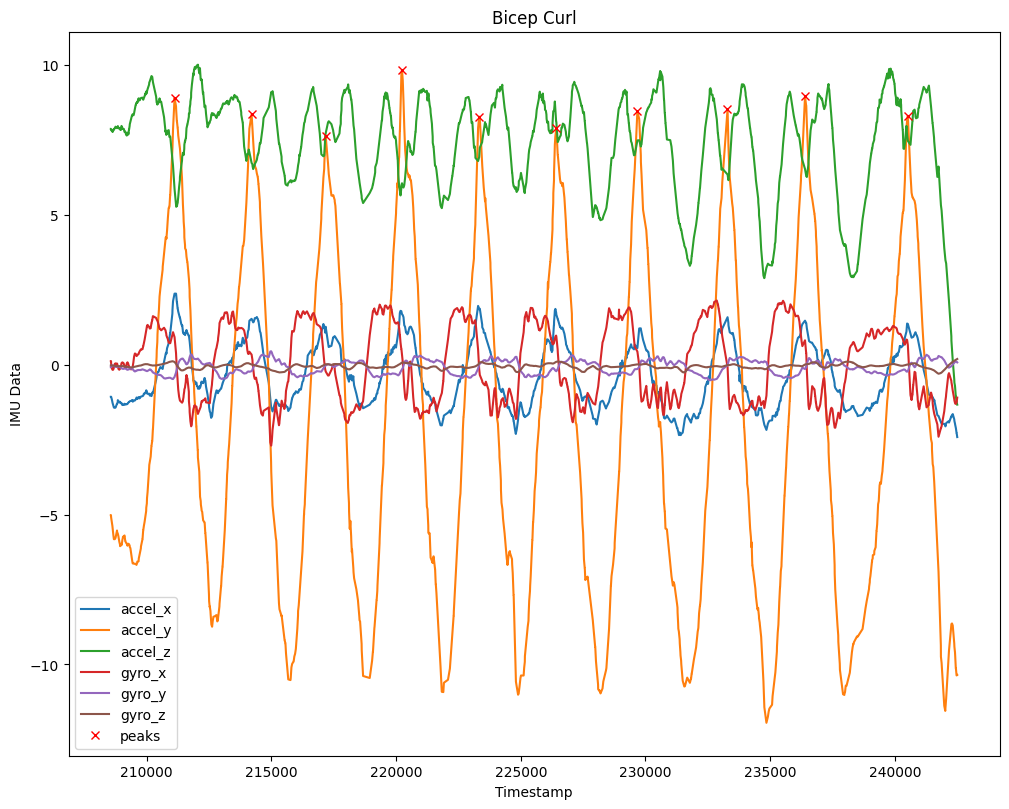

In [158]:
file = "../data2/bicep_curl/bicep_udai_set1_reps10_1.csv"
df = create_df(file)
plot_df(df, "Bicep Curl")

../data2/rdl/rdl_suzan_set1_reps10_1.csv
   timestamp  accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z
0     480234    0.437   -8.151    5.543   0.123  -0.131  -0.007
1     480237    0.450   -8.054    5.636   0.076  -0.134  -0.012
2     480241    0.450   -8.054    5.636   0.076  -0.134  -0.012
3     480244    0.450   -8.054    5.636   0.076  -0.134  -0.012
4     480265    0.433   -8.520    5.476   0.050  -0.123  -0.007
{'peak_heights': array([], dtype=float64)}
peaks: []


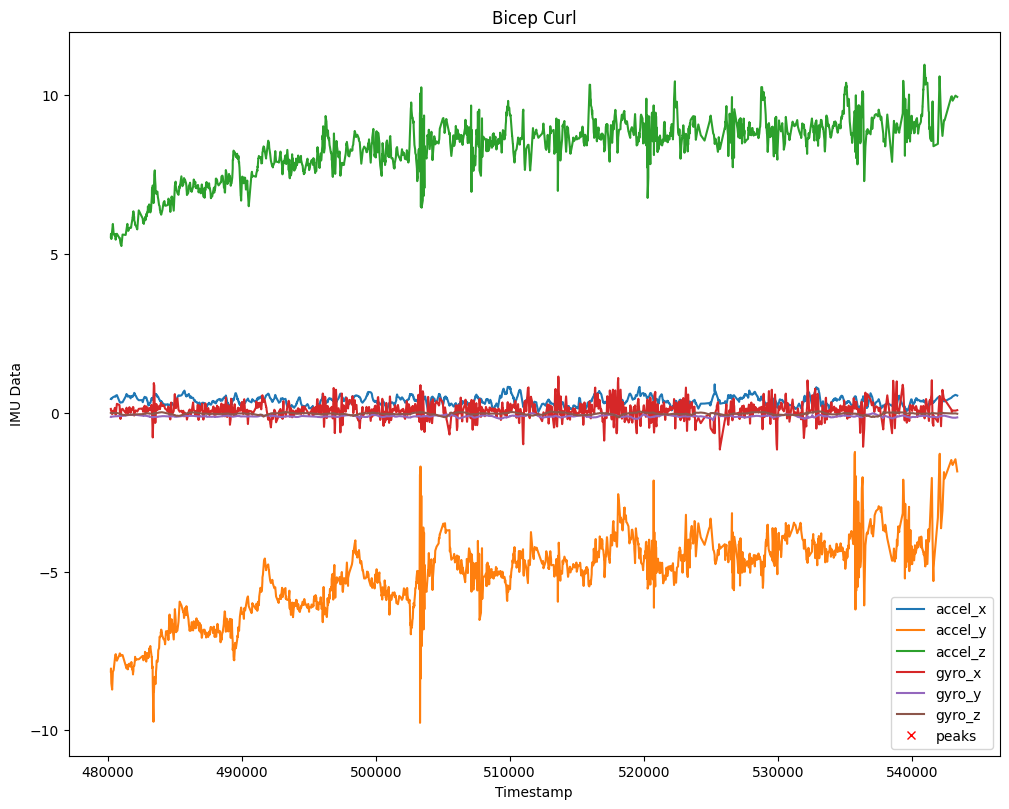

In [159]:
file = "../data2/rdl/rdl_suzan_set1_reps10_1.csv"
df = create_df(file)
plot_df(df, "Bicep Curl")

../data2/rdl/rdl_jake_set1_reps10_1.csv
   timestamp  accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z
0     691338    0.184    0.044   10.037   0.081  -0.105  -0.005
1     691342    0.184    0.044   10.037   0.081  -0.105  -0.005
2     691345    0.184    0.044   10.037   0.081  -0.105  -0.005
3     691349    0.209    0.044   10.013   0.088  -0.110  -0.007
4     691371    0.203    0.166   10.004   0.073  -0.110  -0.007
{'peak_heights': array([0.383, 0.335, 1.717, 1.036, 1.841, 1.21 , 2.14 , 2.595, 1.618,
       2.655, 3.281, 2.114, 3.723, 4.031, 3.072, 4.33 , 3.132, 3.965,
       3.716])}
peaks: [  79  205  326  455  607  744  871 1105 1253 1383 1616 1750 1896 2136
 2264 2432 2553 2727 2849]


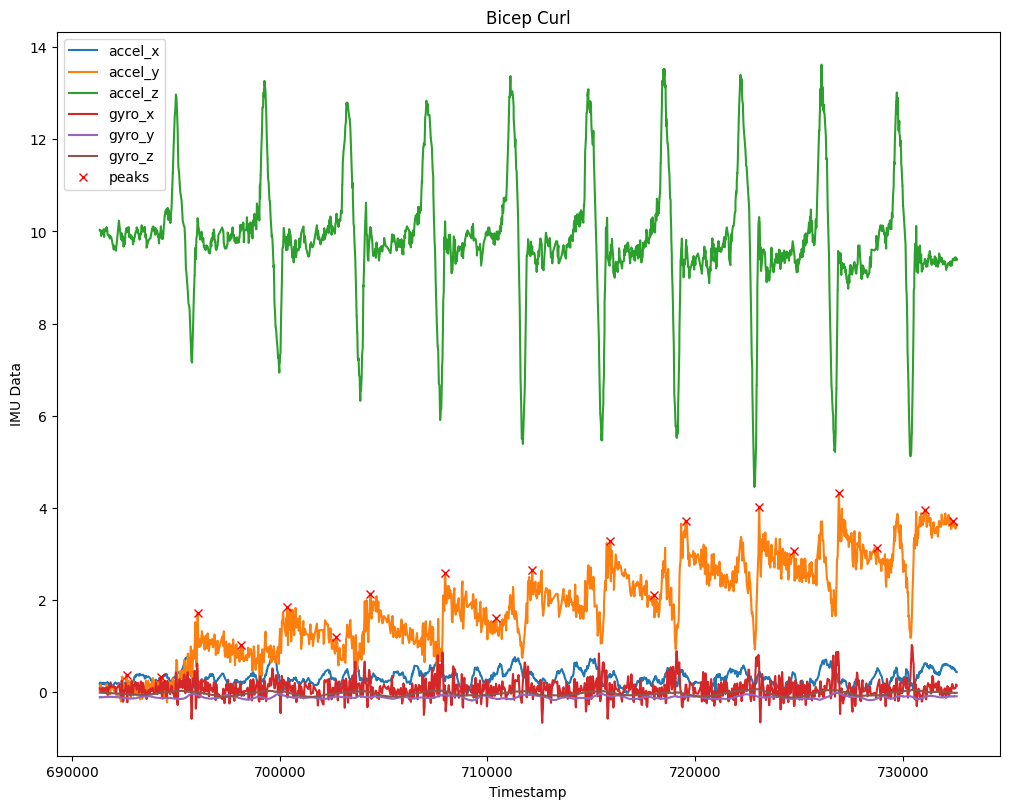

In [160]:
file = "../data2/rdl/rdl_jake_set1_reps10_1.csv"
df = create_df(file)
plot_df(df, "Bicep Curl")

../data2/rdl/rdl_udai_set1_reps10_1.csv
   timestamp  accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z
0     615410    0.167   -8.305    4.982   0.144  -0.111  -0.034
1     615414    0.171   -8.266    4.963   0.158  -0.116  -0.037
2     615416    0.171   -8.266    4.963   0.158  -0.116  -0.037
3     615420    0.171   -8.266    4.963   0.158  -0.116  -0.037
4     615471    0.184   -8.414    5.034   0.134  -0.116  -0.035
{'peak_heights': array([], dtype=float64)}
peaks: []


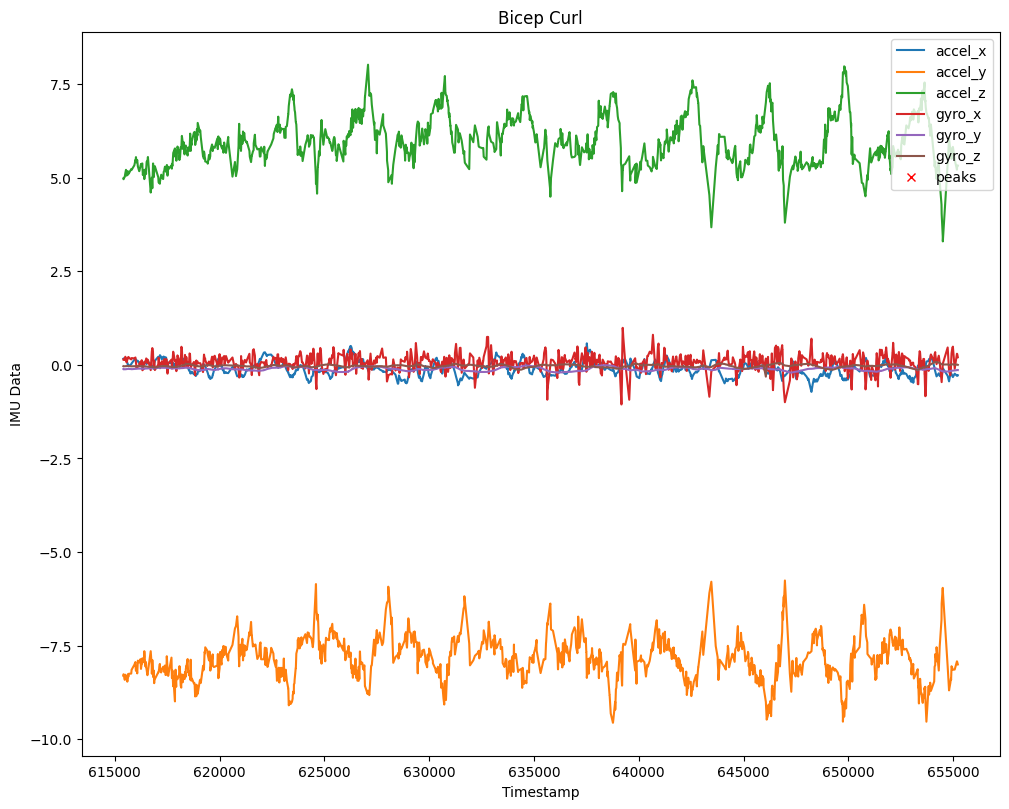

In [161]:
file = "../data2/rdl/rdl_udai_set1_reps10_1.csv"
df = create_df(file)
plot_df(df, "Bicep Curl")

../data2/row/row_suzan_set1_reps10_1.csv
   timestamp  accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z
0     695771   -0.530   -6.700    8.566  -0.130  -0.075  -0.020
1     695775   -0.554   -6.541    8.211   0.050  -0.086  -0.012
2     695778   -0.554   -6.541    8.211   0.050  -0.086  -0.012
3     695782   -0.554   -6.541    8.211   0.050  -0.086  -0.012
4     695804   -0.457   -5.760    8.100   0.496  -0.136  -0.007
{'peak_heights': array([], dtype=float64)}
peaks: []


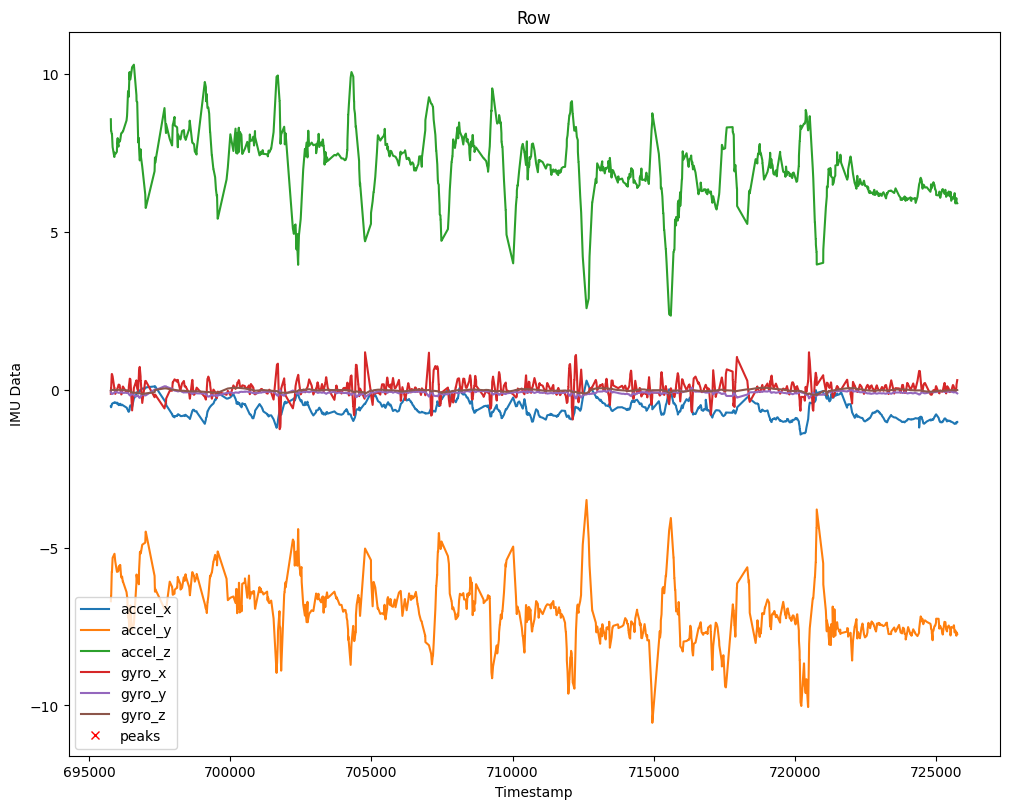

In [162]:
file = "../data2/row/row_suzan_set1_reps10_1.csv"
df = create_df(file)
plot_df(df, "Row")

../data2/row/row_jake_set1_reps12_1.csv
   timestamp  accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z
0     898566    0.476    1.366   10.038   0.084  -0.115  -0.031
1     898569    0.499    1.366   10.038   0.042  -0.098  -0.023
2     898573    0.499    1.366   10.038   0.042  -0.098  -0.023
3     898577    0.474    1.365    9.988   0.020  -0.103  -0.032
4     898628    0.530    1.326    9.945   0.077  -0.100  -0.029
{'peak_heights': array([1.865, 2.091, 2.569, 2.506, 2.789, 1.74 , 1.903, 1.652, 2.188,
       1.864, 2.377, 2.352, 2.596, 1.7  ])}
peaks: [  30  235  371  546  732  912 1134 1310 1497 1666 1837 1983 2143 2264]


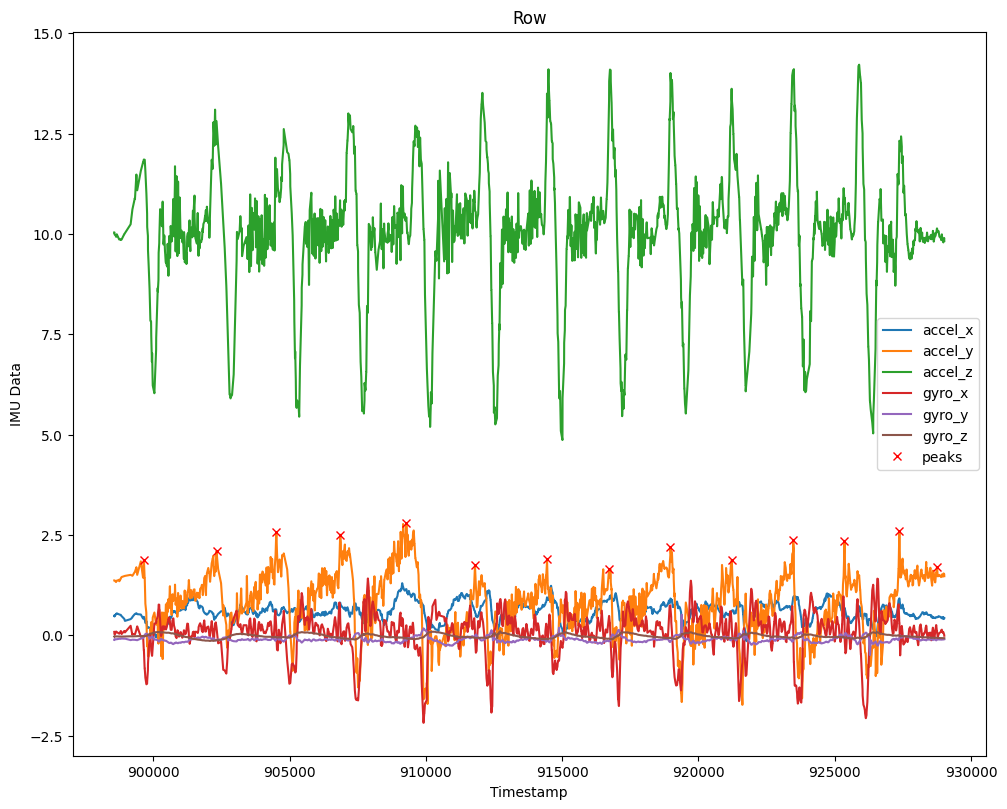

In [163]:
file = "../data2/row/row_jake_set1_reps12_1.csv"
df = create_df(file)
plot_df(df, "Row")

../data2/row/row_udai_set1_reps12_1.csv
   timestamp  accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z
0     783218    0.329    2.722    9.705   0.158  -0.103  -0.011
1     783222    0.329    2.722    9.705   0.158  -0.103  -0.011
2     783225    0.329    2.722    9.705   0.158  -0.103  -0.011
3     783229    0.307    2.773    9.521   0.170  -0.110  -0.013
4     783251    0.275    2.545    9.411   0.130  -0.104  -0.012
{'peak_heights': array([4.554, 6.575, 6.134, 5.082, 6.467, 6.075, 6.431, 5.993, 6.038,
       6.238, 5.024, 5.652])}
peaks: [  97  222  442  577  717  843  969 1100 1230 1367 1490 1644]


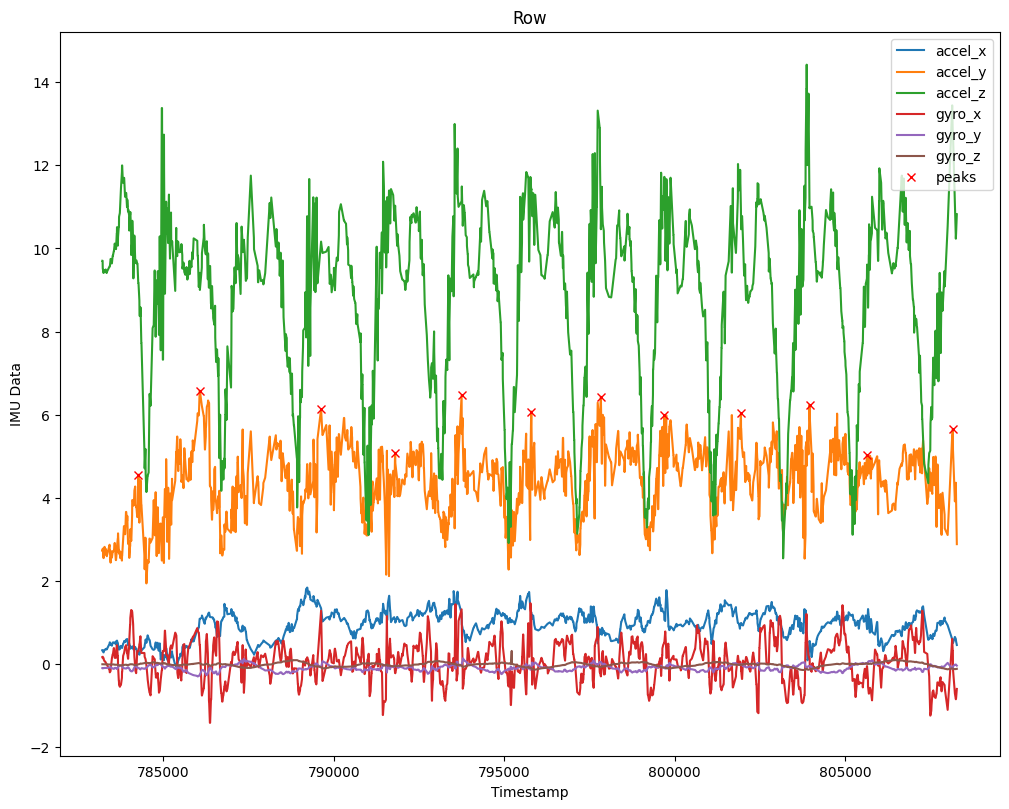

In [164]:
file = "../data2/row/row_udai_set1_reps12_1.csv"
df = create_df(file)
plot_df(df, "Row")

../data2/shoulder_press/shoulder_suzan_set1_reps10_1.csv
   timestamp  accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z
0     143074    1.015    5.903   -8.028  -0.013  -0.020  -0.160
1     143078    1.068    5.945   -7.883  -0.013  -0.020  -0.169
2     143081    1.068    5.945   -7.883   0.001  -0.044  -0.169
3     143188    0.833    6.165   -7.199   0.062  -0.039  -0.132
4     143257    0.559    6.101   -7.700   0.512  -0.072  -0.112
{'peak_heights': array([ 6.165,  2.894,  8.717, 11.433, 12.615, 13.485, 11.933, 12.829,
       13.184, 11.894, 12.026, 10.889, 10.114])}
peaks: [   3  124  273  414  627  805  960 1168 1341 1518 1711 1946 2094]


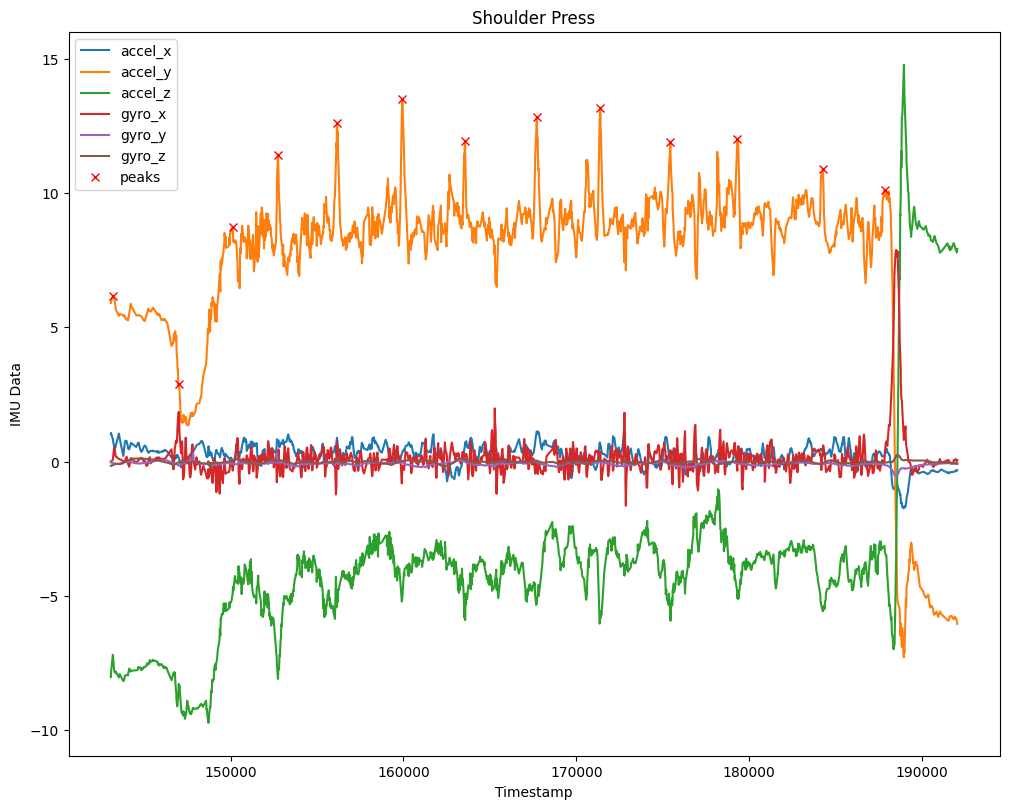

In [166]:
file = "../data2/shoulder_press/shoulder_suzan_set1_reps10_1.csv"
df = create_df(file)
plot_df(df, "Shoulder Press")

../data2/squat/squat_suzan_set1_reps10_1.csv
   timestamp  accel_x  accel_y  accel_z  gyro_x  gyro_y  gyro_z
0    1206809    0.068   -8.813    4.999  -0.134  -0.117  -0.042
1    1206813    0.068   -8.813    4.999  -0.134  -0.117  -0.042
2    1206816    0.068   -8.813    4.999  -0.134  -0.117  -0.042
3    1206820    0.022   -8.771    4.887  -0.089  -0.127  -0.046
4    1206841    0.017   -8.722    4.914   0.006  -0.111  -0.033
{'peak_heights': array([], dtype=float64)}
peaks: []


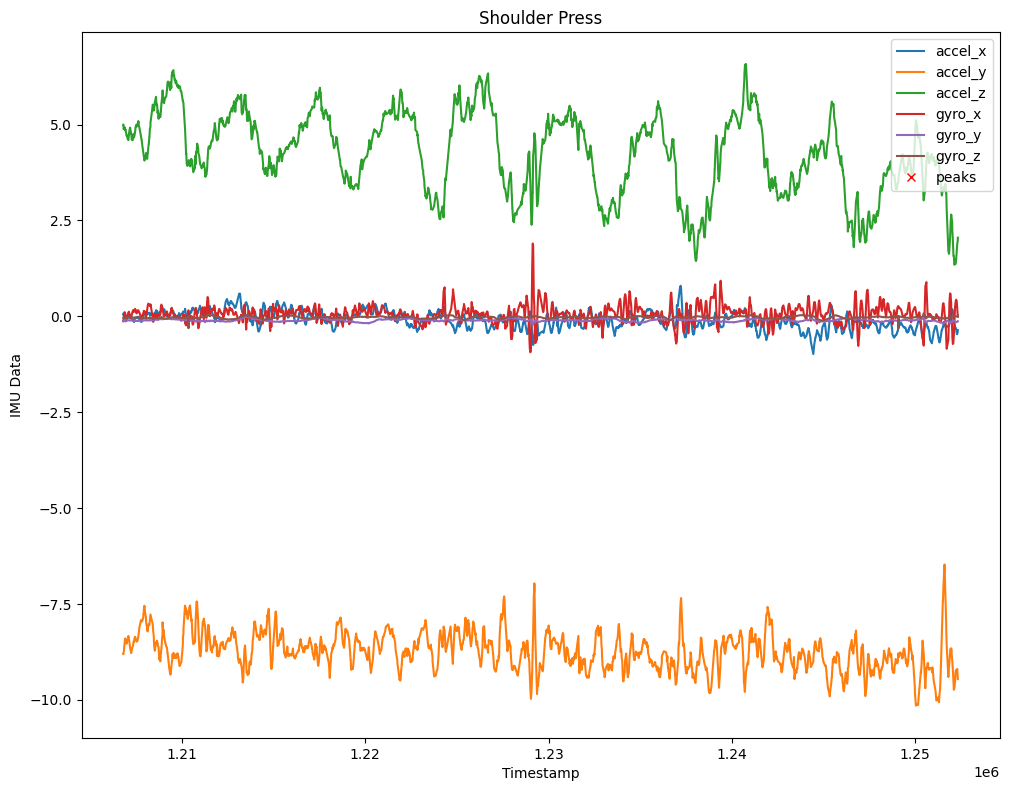

In [167]:
file = "../data2/squat/squat_suzan_set1_reps10_1.csv"
df = create_df(file)
plot_df(df, "Shoulder Press")